In [16]:
# 📌 1. Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [26]:
data_dir = "/content/dataset/DataSet/DataSet"  # Step 2: Data Preprocessing and Splitting

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

class_names = dataset.classes
print("Classes:", class_names)


Classes: ['Data_cloudy', 'Data_desert', 'Data_green_area', 'Data_water']


In [27]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CustomCNN(num_classes=4).to(device)


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []


In [29]:
for epoch in range(3):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    train_acc = 100 * correct / total
    train_loss_list.append(train_loss / len(train_loader))
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    val_acc = 100 * correct / total
    val_loss_list.append(val_loss / len(val_loader))
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/3 | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Epoch 1/3 | Train Acc: 70.08% | Val Acc: 73.33%
Epoch 2/3 | Train Acc: 80.95% | Val Acc: 80.37%
Epoch 3/3 | Train Acc: 85.08% | Val Acc: 75.93%


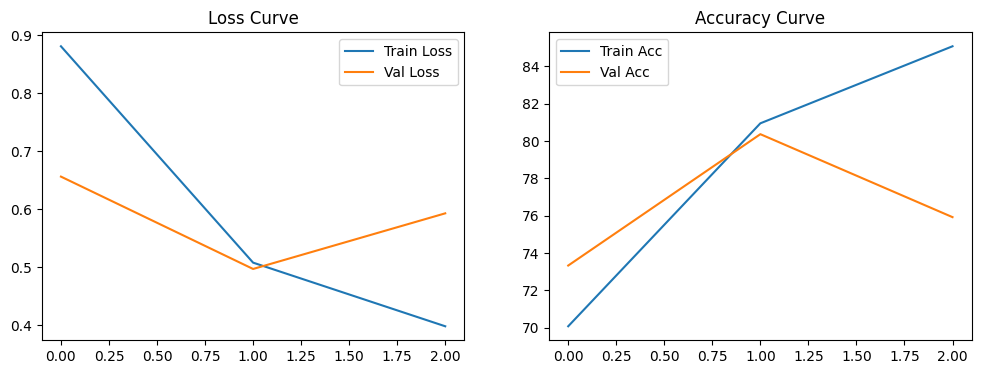

In [30]:
# 📌 7. Accuracy & Loss Graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


                 precision    recall  f1-score   support

    Data_cloudy       0.86      0.56      0.68        77
    Data_desert       0.68      0.99      0.81        68
Data_green_area       0.86      0.93      0.89        76
     Data_water       0.87      0.69      0.77        49

       accuracy                           0.80       270
      macro avg       0.82      0.79      0.79       270
   weighted avg       0.82      0.80      0.79       270



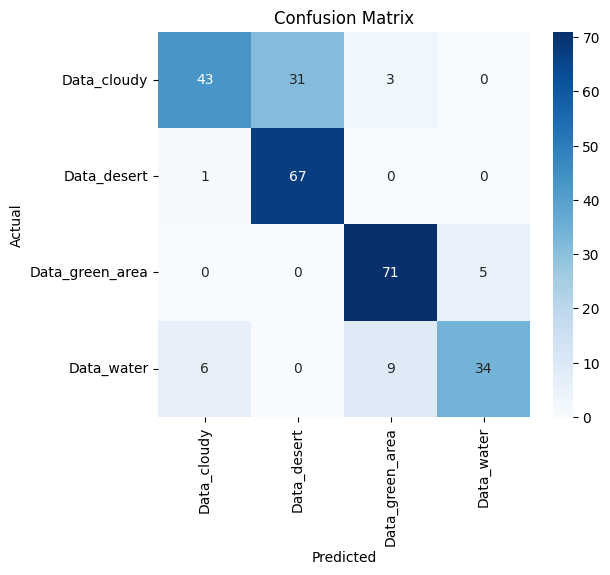

Specificity (per class): [0.96373057 0.84653465 0.93814433 0.97737557]


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Specificity
cm = np.array(cm)
tn = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
fp = cm.sum(axis=0) - np.diag(cm)
specificity = tn / (tn + fp)
print("Specificity (per class):", specificity)
